In [94]:
# import the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, ParameterGrid,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

- Load the train data and using all your knowledge try to explore the different statistical properties of the dataset.

In [161]:
# Code starts here
train = pd.read_csv('train.csv')

#Missing Values
print(train.shape,train.isnull().sum())
train_dropna = train.dropna()
# Code ends here

(66232, 19) Id                    0
item_id               0
waist             63913
size                  0
quality              54
cup size           4952
hips              21332
bra size           4752
category              0
bust              56774
height              886
user_name             0
length               29
fit                   0
user_id               0
shoe size         43918
shoe width        51343
review_summary     5373
review_text        5373
dtype: int64


In [162]:
# Hips missing values imputation
def treat_hips(df):
    bottoms = df[df.category == 'bottoms']
    for i in range(df.shape[0]):
        if np.isnan(df.iloc[i,6]):
            df.iloc[i,6] = bottoms[bottoms['size'] == df.iloc[i,3]]['hips'].mean()
        if np.isnan(df.iloc[i,6]):
            if np.isfinite(df.iloc[i,7]):
                df.iloc[i,6] = bottoms[bottoms['bra size'] == df.iloc[i,7]]['hips'].mean()
        if np.isnan(df.iloc[i,6]):
            df.iloc[i,6] = bottoms[bottoms['height'] == df.iloc[i,10]]['hips'].mean()      
        if np.isnan(df.iloc[i,6]):
            df.hips.fillna(df.hips.mean(),inplace = True)

    df.hips = df.hips.apply(lambda x: round(x,2))
    return df
train = treat_hips(train)

In [163]:
# bra size missing values imputation
def treat_brasize(df):
    tops = df[df.category == 'tops']
    tops['hips'] = tops['hips'].apply(lambda x: round(x))
    for i in range(df.shape[0]):
        if np.isnan(df.iloc[i,7]):
            if pd.isnull(df.iloc[i,9]):
                pass
            else:
                df.iloc[i,7] = tops[tops['bust'] == df.iloc[i,9]]['hips'].mean()
        if np.isnan(df.iloc[i,7]):
            if pd.isnull(df.iloc[i,2]):
                pass
            else:
                df.iloc[i,7] = tops[tops['waist'] == df.iloc[i,2]]['hips'].mean()
        if np.isnan(df.iloc[i,7]):
            if pd.isnull(df.iloc[i,6]):
                pass
            else:
                df.iloc[i,7] = tops[tops['hips'] == round(df.iloc[i,6])]['hips'].mean()
    return df
train = treat_brasize(train)

In [164]:
# cup size missing values imputation
def treat_cupsize(df):
    tops = df[df.category == 'tops']
    tops['bra size'] = tops['bra size'].apply(lambda x: round(x))
    for i in range(df.shape[0]):
        if pd.isnull(df.iloc[i,5]):
            if df[df['bra size'] == round(df.iloc[i,7])]['cup size'].mode().shape[0] > 0:
                df.iloc[i,5] = df[df['bra size'] == round(df.iloc[i,7])]['cup size'].mode()[0]

        if pd.isnull(df.iloc[i,5]):
            if tops[tops['size'] == round(df.iloc[i,3])]['cup size'].mode().shape[0] > 0:
                df.iloc[i,5] = tops[tops['size'] == round(df.iloc[i,3])]['cup size'].mode()[0]

    for i in range(df.shape[0]):
        if pd.isnull(df.iloc[i,5]):
            if df[df['bra size'] == round(df.iloc[i,7])]['cup size'].mode().shape[0] > 0:
                df.iloc[i,5] = df[df['bra size'] == round(df.iloc[i,7])]['cup size'].mode()[0]
    return df
train = treat_cupsize(train)

In [165]:
# Quality missing values imputation
def treat_quality(df):
    for i in range(df.shape[0]):
        if pd.isnull(df.iloc[i,4]):
            df.iloc[i,4] = df[df['item_id'] == round(df.iloc[i,1])]['quality'].mean()

        if pd.isnull(df.iloc[i,4]):
            df.iloc[i,4] = df[df['category'] == df.iloc[i,8]]['quality'].mean()
    return(df)
train = treat_quality(train)

In [166]:
# length missing values imputation 
def treat_length(df):
    for i in range(df.shape[0]):
        if pd.isnull(df.iloc[i,12]):
            if (len(df[(df['height'] == df.iloc[i,10]) & (df['size'] == df.iloc[i,3])]['length'])) > 0:
                df.iloc[i,12] = df[(df['height'] == df.iloc[i,10]) & (df['size'] == df.iloc[i,3])]['length'].mode()[0]
            else:
                df.iloc[i,12] = df.iloc[:,12].mode()[0]
                
    return(df)
train = treat_length(train)

In [167]:
# height
def treat_height(df):
    for i in range(df.shape[0]):
        if pd.isnull(df.iloc[i,10]):
            if (len(df[(df['length'] == df.iloc[i,12]) & (df['size'] == df.iloc[i,3])]['height'])) > 0:
                df.iloc[i,10] = df[(df['length'] == df.iloc[i,12]) & (df['size'] == df.iloc[i,3])]['height'].mode()[0]
    return df
train = treat_height(train)

In [168]:
#drop columns
def drop_cols(df):
    df.drop(['Id','item_id','waist','bust','user_name','user_id','shoe size','shoe width','review_summary','review_text'],axis = 1, inplace = True)
    return df
train = drop_cols(train)

In [169]:
# convert hight to inch
def convert_height(df):
    for i in range(df.shape[0]):
        o_height = df.iloc[i,6].split()
        if len(o_height) == 2:
            if len(o_height[1]) == 4:
                n_height = int(o_height[0][0]) * 12 + int(o_height[1][0:2])
            else:
                n_height = int(o_height[0][0]) * 12 + int(o_height[1][0])
        else:
            n_height = int(o_height[0][0]) * 12

        df.iloc[i,6] = n_height
    return df
train = convert_height(train)

### Visualize the data

- Check for the categorical & continuous features. 
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots.
- Clean the data, apply some data preprocessing and engineering techniques.

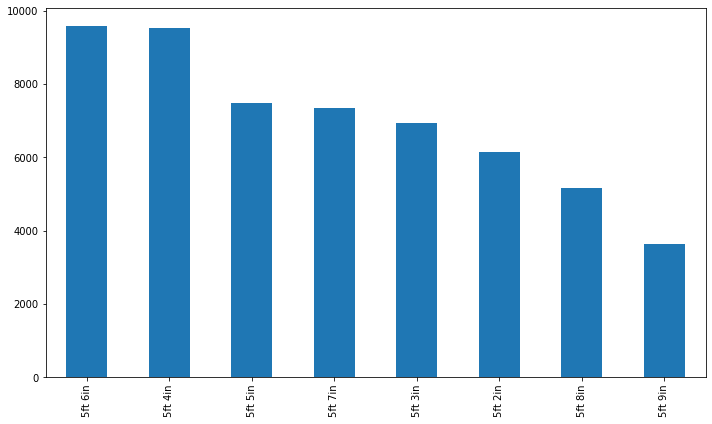

In [112]:
# Most common Heights
train['height'].value_counts()[:8].plot(kind = 'bar', figsize = (10,6))
plt.tight_layout()

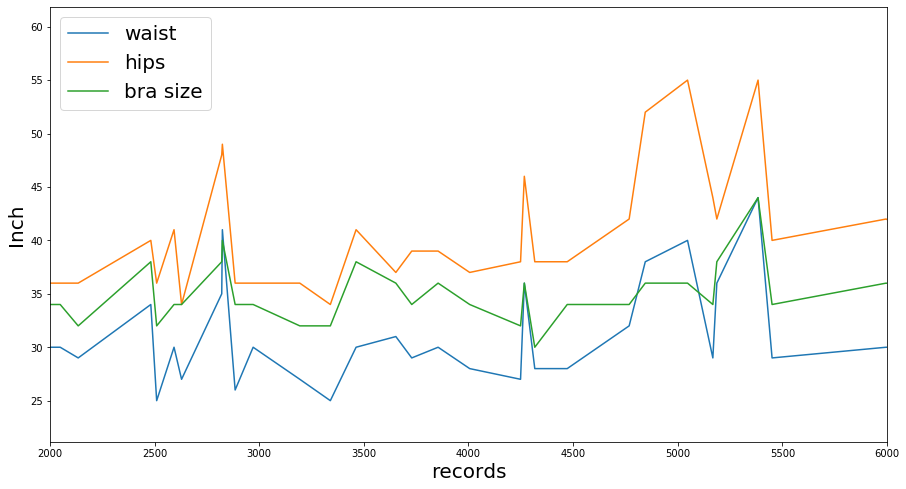

In [159]:
# Body measurements are proportional
plt.figure(figsize = (15,8))
train.dropna().waist.plot()
train.dropna().hips.plot()
train.dropna()['bra size'].plot()
plt.xlim(2000,6000)
plt.xlabel('records', fontsize = 20)
plt.ylabel('Inch',  fontsize = 20)
plt.legend(fontsize = 20)

In [148]:
#Most common Dresses
print('Dress id  Number')
train.item_id.value_counts()[:10]

Dress id  Number


539980    1630
668696    1245
397005    1199
175771    1140
407134    1115
391519     995
412737     985
169727     869
486643     822
210299     814
Name: item_id, dtype: int64

In [101]:
# Cupsize vs Brasize
train.groupby('cup size')['bra size'].value_counts().sort_values(ascending = False)[:20]
#plt.ylabel()

cup size  bra size
b         34.0        4985
c         36.0        4510
          34.0        4256
d         36.0        3451
b         36.0        3275
d         34.0        3121
c         38.0        2609
d         38.0        2368
dd/e      36.0        2252
a         34.0        2087
dd/e      34.0        2007
          38.0        1860
b         32.0        1749
c         32.0        1693
d         32.0        1472
          40.0        1206
dd/e      32.0        1130
b         38.0        1119
dd/e      40.0        1024
ddd/f     38.0         921
Name: bra size, dtype: int64

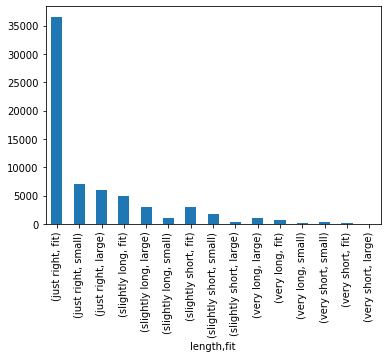

In [93]:
# Most of the dresses fit well
train.groupby('length')['fit'].value_counts().plot(kind = 'bar')
plt.title('No. of dress vs Kind of fit & length')

In [170]:
#label encoding
def encode_cols(df):
    cols = ['cup size', 'category', 'length']
    for i in cols:
        dum = pd.get_dummies(df[i], drop_first = True, prefix=i, prefix_sep='_',)
        df = df.join(dum)
        df.drop(i,axis = 1, inplace = True)
    return(df)
train = encode_cols(train)

In [171]:
# encode target
train.fit = train.fit.apply(lambda x : 0 if x == 'small' else (1 if x == 'fit' else 2))

### Model building

- Split the data into train and test.
- Now let's come to the actual task, predict the values of `fit` after building a Machine learning model.
- Try improving upon the `accuracy_score` ([Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html))

In [24]:
# Separate Target
X = train.drop('fit', axis = 1)
y = train['fit'].copy()

# feature scaling
ss = StandardScaler()
X = ss.fit_transform(X)

In [25]:
# split the data
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.3)

In [26]:
# cross validation
lr_cv = LogisticRegression()
dt_cv = DecisionTreeClassifier()
rf_cv = RandomForestClassifier()
xgb_cv = XGBClassifier()

cv_lr = cross_val_score(lr_cv, X, y, cv = 8, scoring = 'accuracy').mean()
print('For lr :', cv_lr)
cv_dt = cross_val_score(dt_cv, X, y, cv = 8, scoring = 'accuracy').mean()
print('For dt :', cv_dt)
cv_rf = cross_val_score(rf_cv, X, y, cv = 8, scoring = 'accuracy').mean()
print('For RandomForestRegressor :', cv_rf)
cv_xgb = cross_val_score(xgb_cv, X, y, cv = 8, scoring = 'accuracy').mean()
print('For xgb :', cv_xgb)

'without rfe\nFor lr : 0.6984690179973426\nFor dt : 0.5709022828844064\nFor RandomForestRegressor : 0.6607078149534968\nFor xgb : 0.6981217538350042'

In [27]:
# Logistic Regression
lr = LogisticRegression()

param_grid = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','newton-cg', 'lbfgs', 'liblinear']}
    
lr_ht = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
lr_ht.fit(xtrain, ytrain)

print(lr_ht.best_params_)
print(lr_ht.best_score_)

"lr = LogisticRegression()\n\nparam_grid = {'penalty' : ['l1', 'l2'],\n    'C' : np.logspace(-4, 4, 20),\n    'solver' : ['liblinear','newton-cg', 'lbfgs', 'liblinear']}\n    \nlr_ht = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)\nlr_ht.fit(xtrain, ytrain)\n\nprint(lr_ht.best_params_)\nprint(lr_ht.best_score_)"

In [28]:
# XGBClassifier hyperparameter tuning
xgb = XGBClassifier()
param_xgb = {
    'max_depth' : [2],
    'min_child_weight' : [4],
    'n_estimators' : [5500], #85
    'gamma' : [0],
    'subsample':[0.9],
    'colsample_bytree':[0.5],
    'reg_alpha':[0.005],
    'learning_rate' : [0.01]
}

xgb_ht = GridSearchCV(xgb, param_grid = param_xgb, cv = 5, verbose=True, n_jobs=-1)
xgb_ht.fit(xtrain,ytrain)

print(xgb_ht.best_params_)
print(xgb_ht.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.9min finished


{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 5500, 'reg_alpha': 0.005, 'subsample': 0.9}
0.6987404124548368


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [54]:
# Function to preprocess testing data
def format_data(test):
    test = treat_hips(test)
    test = treat_brasize(test)
    test = treat_cupsize(test)
    test = treat_quality(test)
    test = treat_length(test)
    test = treat_height(test)
    test = drop_cols(test)
    test = convert_height(test)
    test = encode_cols(test)
    test = ss.fit_transform(test)
    return test

In [57]:
# Import & treat test data
test = pd.read_csv('test.csv')
testid = test['Id'].copy()

test = format_data(test)

In [43]:
#Predict Fit for testing data
result = xgb_ht.predict(test)

In [46]:
# Reverse encoding predicted values
sub1 = []
for i in range(len(result)):
    sub1.append('small' if result[i] == 0 else ('fit' if result[i] == 1 else 'large'))

In [49]:
# Save file for submission
subm = pd.DataFrame({'Id':testid,'fit':sub1})
#subm.to_csv('sub1.csv', index = False)